## Report project basic of mobile robotics - group 17
### About us

### Project description

### Code implementation
##### 0. Import needed libraries


In [1]:
from vision.map import * # Import map library
from tdmclient import ClientAsync # Import thymio library
from utils.exceptions import * # Import exceptions
from global_navigation.main import *
from vision.camera import *
from utils.settings import *
import time
import math

## 1. Computer Vision
### 1.1. Map creation
#### 1.1.1 Data loading and needed variables initialization

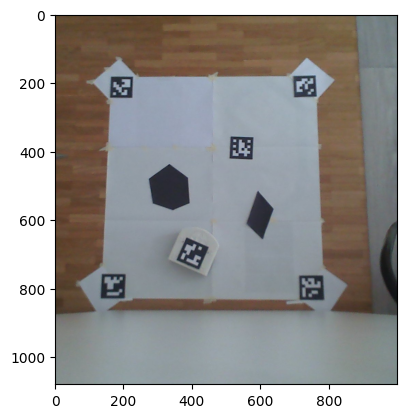

In [2]:
# Prepare data for the demo
camera_frame_path = "report_images/vision/camera_frame.jpg"

# Initialize the map (load an image from a file) 
cam = Camera(frame_path=camera_frame_path)
frame,_ = cam.get_frame()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(frame[:,500:1500,:])
plt.show()

#### 1.1.2 Corners detection and definition of the transformation matrix 

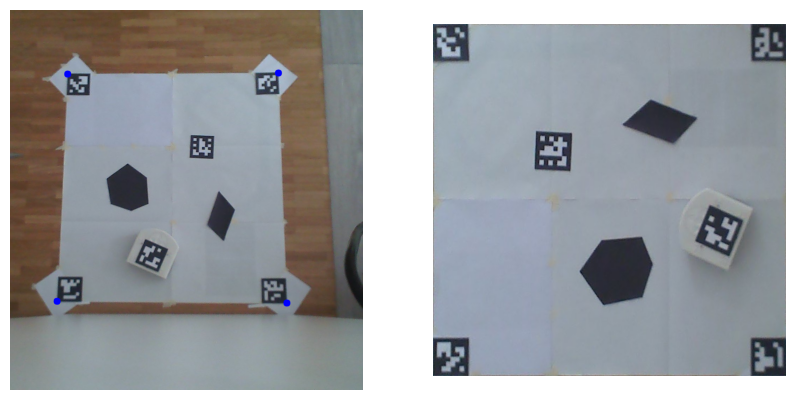

In [3]:
# Detect the corners markers
markers = Marker()
detected_markers = markers.detect(cam,n_iterations=1)
frame_with_markers = frame.copy()
# Display the coordinates of the markers on the image
for k in detected_markers.keys():
    if k in IDS_CORNER_MARKERS:
        marker = detected_markers[k]
        # Draw the origin of the marker with a different color
        cv2.circle(frame_with_markers,tuple(np.array(marker["points"][0]).astype(int)),10,(0,0,255),-1)

# Use the markers found to compute a transformation matrix such the corner markers are in the vertices of a square
_,frame_cut = cam.get_frame()
frame_cut = cv2.cvtColor(frame_cut, cv2.COLOR_BGR2RGB)

# Display frame with markers next to frame_cut
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_with_markers[:,500:1500,:])
ax[1].imshow(frame_cut)
# Remove the axis
for a in ax:
    a.axis("off")
plt.show()

#### 1.1.3 Obstacles detection and enlargement

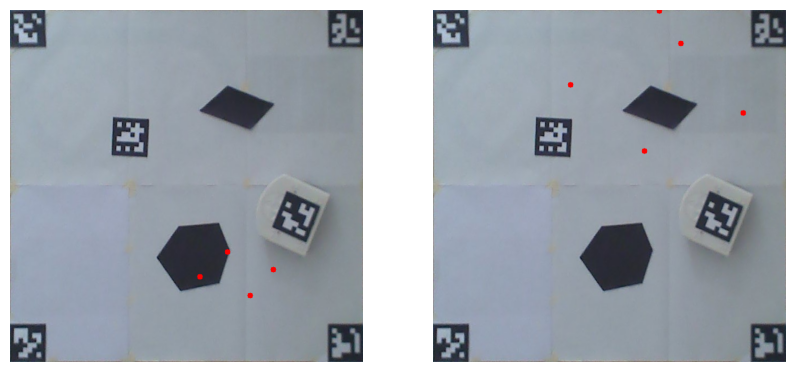

In [6]:
# Create a map
m = Map(cam)
# Find the obstacles
m.findObstacles(number_of_obstacles=2)
# Create a map with the obstacles vertices
map_with_obstacles = frame_cut.copy()
# Draw the original obstacles on the map_with_obstacles
for obstacle in m.obstacles_original:
    for p in obstacle:
        pinv = p.copy()
        # Invert the y coordinate
        pinv[1] = frame_cut.shape[0]-pinv[1]
        pinv = tuple(np.array(pinv).astype(int))
        cv2.circle(map_with_obstacles,pinv,5,(255,0,0),-1)
# Create a map with the enlarged obstacles
map_with_enlarged_obstacles = frame_cut.copy()
# Draw the enlarged obstacles on the map_with_enlarged_obstacles
for obstacle in m.obstacles:
    for p in obstacle:
        pinv = p.copy()
        # Invert the y coordinate
        #pinv[1] = frame_cut.shape[0]-pinv[1]
        pinv = tuple(np.array(pinv).astype(int))
        cv2.circle(map_with_enlarged_obstacles,pinv,5,(255,0,0),-1)
# Display the maps
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(map_with_obstacles)
ax[1].imshow(map_with_enlarged_obstacles)
# Remove the axis
for a in ax:
    a.axis("off")
plt.show()


#### 1.1.4 Final goal and initial position detection

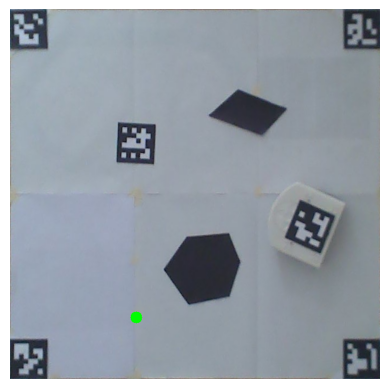

In [7]:
# Find initial and final positions
initial, final = m.getInitialFinalPoints()

# Display the initial and final positions
map_with_initial_final = frame_cut.copy()
# Draw the initial and final positions on the map_with_initial_final
for p in [initial,final]:
    pinv = p.copy()
    # Invert the y coordinate
    pinv[1] = frame_cut.shape[0]-pinv[1]
    pinv = tuple(np.array(pinv).astype(int))
    cv2.circle(map_with_initial_final,pinv,10,(0,255,0),-1)
# Display the map
plt.imshow(map_with_initial_final)
plt.axis("off")
plt.show()

#### 1.1.5 Map creation

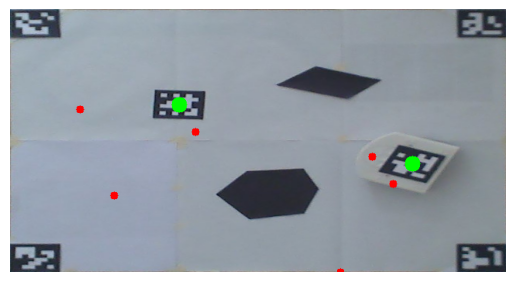

In [6]:
# Insert enlarged obstacles, initial and final positions in the map
fullMap = frame_cut.copy()

# Draw the enlarged obstacles on the fullMap
for obstacle in m.obstacles:
    for p in obstacle:
        # Invert the y coordinate
        p_inv = p.copy()
        p_inv[1] = frame_cut.shape[0]-p[1]
        p_inv = tuple(np.array(p_inv).astype(int))
        cv2.circle(fullMap,p_inv,5,(255,0,0),-1)

# Draw the initial and final positions on the fullMap
for p in [initial,final]:
    # Invert the y coordinate
    p_inv = p.copy()
    p_inv[1] = frame_cut.shape[0]-p[1]
    p_inv = tuple(np.array(p_inv).astype(int))
    cv2.circle(fullMap,p_inv,10,(0,255,0),-1)

# Display the map
plt.imshow(fullMap)
plt.axis("off")
plt.show()

### 1.2 Real time detection of position and orientation

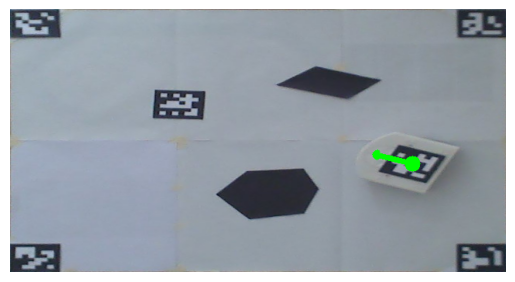

In [7]:
# Draw the position and the orientation
orientationPositionMap = frame_cut.copy()

# Obtain the position and the orientation
p,theta = m.cameraRobotSensing()

# Draw the robot position
p_inv = p.copy()
p_inv[1] = frame_cut.shape[0]-p[1]
p_inv = tuple(np.array(p_inv).astype(int))
cv2.circle(orientationPositionMap,p_inv,10,(0,255,0),-1)

# Draw the robot orientation
p2 = (p_inv[0]+50*np.cos(theta),p_inv[1]-50*np.sin(theta))
p2 = tuple(np.array(p2).astype(int))
cv2.arrowedLine(orientationPositionMap,p_inv,p2,(0,255,0),5)

# Display the map
plt.imshow(orientationPositionMap)
plt.axis("off")
plt.show()

## 2. Global Navigation
### 2.1 Needed variables definition

In [8]:
glob = Global(m.obstacles)

### 2.2 Creation of the visibility graph

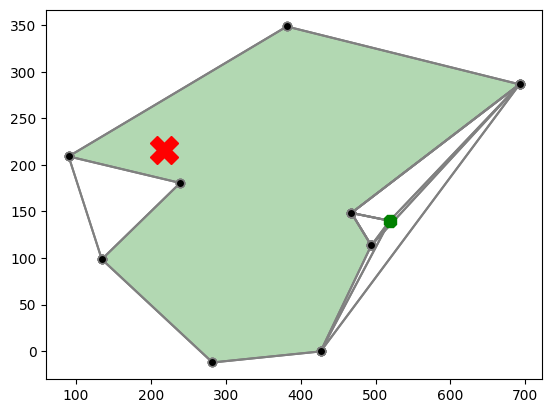

In [9]:
# Create visibility graph,and plot it
glob.initialPoint = initial
glob.finalPoint = final

glob.plot_visibility()

### 2.3 Dijkstra algorithm

In [10]:
glob.find_optimal_path(initial, final)
m.plot(initial, final, path= glob.optimal_path)

KeyError: 1

### 2.4 Global controller

## 3. Local Navigation

## 4. Filtering

## 5. Demo

In [14]:
from vision.map import * # Import map library
from tdmclient import ClientAsync # Import thymio library
from utils.exceptions import * # Import exceptions
from utils.logger import * # Import logger
from global_navigation.main import *
from local_navigation.localNav import *
from vision.camera import *
from utils.settings import *
from time import *

##### Variables definition #####
start = goal = None

try:
    ##### Connection to the robot #####
    client = ClientAsync()
    node = await client.wait_for_node()
    await node.lock()

    ##### Map creation and variables definition #####
    cam = Camera()
    map = Map(cam)
    map.findObstacles()
    glob = Global(map.obstacles)
    #local = Local()
    #kalman = Kalman()

    ##### Loop #####
    while not glob.goal_reached:        
        # Final and initial position estimation and path planning
        if start is None or goal is None:
            start, goal = map.getInitialFinalPoints()
            glob.find_optimal_path(start, goal)
            time_last_sample = time.time()
            time_sampling = None            
            continue

        # Sensing
        await node.wait_for_variables() # Wait for the sensors to be updated
        cameraPos_measured, cameraOrientation_measured = map.cameraRobotSensing() # Robot position and orientation from the camera
        prox_horizontal_measured = node["prox.horizontal"] # Horizontal proximity sensors
        imu_measured = node["acc"] # Accelerometer
        left_speed_measured, right_speed_measured = node["motor.speed"] # Motor speed

        # See if the robot has been kidnapped
        if 22 <= node["acc"][2] <= 24:
            # Kidnapping management
            old_cameraPos = cameraPos_measured
            while True:
                await client.sleep(1)
                await node.wait_for_variables()
                cameraPos_measured,_ = map.cameraRobotSensing()
                if cameraPos_measured != None and np.linalg.norm(cameraPos_measured-old_cameraPos) <= KIDNAPPING_CONV_THRESH and 22 <= node["acc"][2] <= 24:
                    break
                else:
                    old_cameraPos = cameraPos_measured

            # Force a new path planning
            start = None
            goal = None

            # Compute the new position and orientation to display
            cameraPos_measured, cameraOrientation_measured = map.cameraRobotSensing()
        else:
            # Position estimation [TODO]

            # Control [TODO]
            prox_horizontal = node["prox.horizontal"]
            if local.local_obstacle(prox_horizontal):
                motorLeft,motorRight = local.local_controller(prox_horizontal)
            else:
                motorLeft,motorRight = glob.global_controller(cameraPos, cameraOrientation) 

            # Actuation
            v = { "motor.left.target": [round(motorLeft)], "motor.right.target": [round(motorRight)] }
            await node.set_variables(v)

        # Set all the parameters for real time display
        cam.robotEstimatedPosition(cameraPos_measured)
        cam.robotEstimatedOrientation(cameraOrientation_measured)
        if(cam.display()):
            break
        await client.sleep(0.1)

        # Time sampling
        time_sampling = time.time() - time_last_sample
        time_last_sample = time.time()
except Exception as e:
    print(e)
finally:
    # Stop the robot
    v = { "motor.left.target": [round(0)], "motor.right.target": [round(0)] }
    await node.set_variables(v)

    # Unlock the robot
    await node.unlock()

    # Turn off the camera
    cam.release()
    